# Import Library

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
from PIL import Image
import io
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2

print(tf.__version__)


2.12.0


# Add Dataset Model

In [13]:
train_dir = Path('../dataset/')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [14]:
test_dir = Path('../dataset/test/')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [15]:
val_dir = Path('../dataset/validation/')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

# Get Labels With Folder Image

In [16]:
def image_processing(filepath):
    # Create Label
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [17]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

## Looks Dataset

In [18]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3165

Number of different labels: 30

Labels: ['gulai_ikan' 'somay' 'ikan_goreng' 'bakso_kuah' 'mie_goreng'
 'kentang_goreng' 'apel' 'ayam_goreng' 'nasi_goreng' 'sayur_asam'
 'tahu_goreng' 'daging_rendang' 'lemon' 'mangga' 'pempek' 'nanas'
 'opor_ayam' 'pear' 'kacang_rebus' 'sate_bakar' 'gado_gado' 'sayur_bayam'
 'cumi_tepung' 'telur_dadar' 'telur_balado' 'tempe_goreng' 'mie_kuah'
 'ayam_pop' 'pisang' 'semangka']


In [19]:
# Check label ind folder
train_df.head(5)

,Filepath,Label
0,../dataset/train/gulai_ikan/gulai_ikan (47).jpg,gulai_ikan
1,../dataset/train/somay/siomay-bandung-steamed-...,somay
2,../dataset/train/ikan_goreng/mujair-goreng-sam...,ikan_goreng
3,../dataset/test/bakso_kuah/FotoJet-1-277320063...,bakso_kuah
4,../dataset/train/mie_goreng/noodle-egg-top-thi...,mie_goreng


## Test Labels With Image

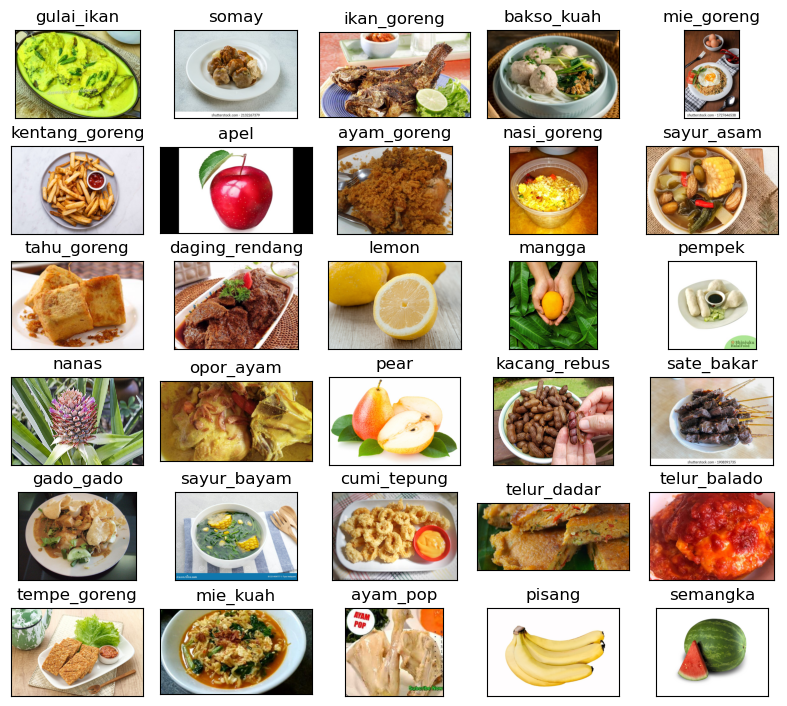

In [20]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Image Preprocessing With MobileNet V2

In [21]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [22]:
# Train Dataset
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3165 validated image filenames belonging to 30 classes.


In [23]:
# Validation dataset
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 498 validated image filenames belonging to 30 classes.


In [24]:
# Testing Dataset
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 498 validated image filenames belonging to 30 classes.


# Train Model Machine Learning With Tranfer Learning MobileNetV2

## Pre Training Model

In [25]:
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

## Callbacks

In [26]:
# Setting Callbacks
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% accuracy in training and 95% in validation, so cancelling training!")
            self.model.stop_training = True

callbackTraining = myCallback()

## Training Model

In [27]:
# Model Layers
model = Sequential([
    tf.keras.layers.Resizing(224, 224), 
    tf.keras.layers.Normalization(axis=-1),
    pretrained_model,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(30, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model (initial training)
history = model.fit(
    train_images, 
    validation_data=val_images, 
    batch_size=32, 
    callbacks=[callbackTraining],
    epochs=50)

Epoch 1/50


2023-12-10 19:32:05.622550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-10 19:32:05.650411: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


99/99 [==============================] - ETA: 0s - loss: 3.2141 - accuracy: 0.1652

2023-12-10 19:33:02.405290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 66s 658ms/step - loss: 3.2141 - accuracy: 0.1652 - val_loss: 2.7946 - val_accuracy: 0.3635
Epoch 2/50
99/99 [==============================] - 64s 644ms/step - loss: 2.3153 - accuracy: 0.4831 - val_loss: 1.7126 - val_accuracy: 0.6767
Epoch 3/50
99/99 [==============================] - 65s 654ms/step - loss: 1.4069 - accuracy: 0.7021 - val_loss: 1.0138 - val_accuracy: 0.7871
Epoch 4/50
99/99 [==============================] - 66s 667ms/step - loss: 0.9380 - accuracy: 0.7949 - val_loss: 0.6785 - val_accuracy: 0.8614
Epoch 5/50
99/99 [==============================] - 70s 706ms/step - loss: 0.7021 - accuracy: 0.8483 - val_loss: 0.5067 - val_accuracy: 0.9056
Epoch 6/50
99/99 [==============================] - 69s 702ms/step - loss: 0.5633 - accuracy: 0.8787 - val_loss: 0.4105 - val_accuracy: 0.9277
Epoch 7/50
99/99 [==============================] - 66s 672ms/step - loss: 0.4688 - accuracy: 0.8989 - val_loss: 0.3196 - val_accuracy: 0.9578
Epoch 8/50

## Arsitektur Model

In [28]:
# Check Arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, None)    0         
                                                                 
 normalization (Normalizatio  (None, 224, 224, 3)      7         
 n)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 30)                3

## Grapic Model

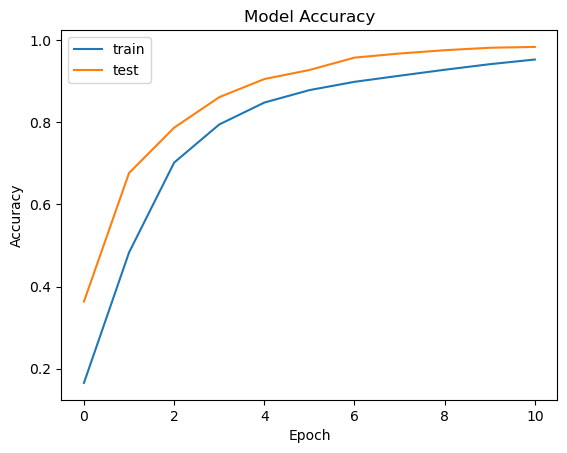

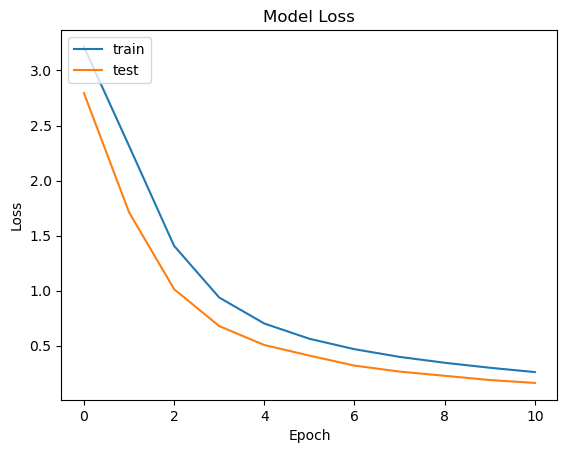

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Check Point Model

In [30]:
# Save the best model during initial training
checkpoint_path = "initial_training_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)


## Setting Callbacks Fine-Tuning

In [31]:
# Setting Callbacks
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% accuracy in training and 95% in validation, so cancelling training!")
            self.model.stop_training = True

callbackFineTuning = myCallback()

## Fine-Tuning Model

In [32]:
# Unfreeze some layers for fine-tuning
for layer in model.layers[:100]: 
    layer.trainable = True

# Recompile the model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Continue training with fine-tuning
history_fine_tuning = model.fit(
    train_images, 
    validation_data=val_images, 
    callbacks=[callbackFineTuning],
    batch_size=32, 
    epochs=50)


Epoch 1/50


2023-12-10 19:44:19.991964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - ETA: 0s - loss: 1.1050 - accuracy: 0.7033

2023-12-10 19:45:59.511507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


99/99 [==============================] - 109s 1s/step - loss: 1.1050 - accuracy: 0.7033 - val_loss: 0.2270 - val_accuracy: 0.9398
Epoch 2/50
99/99 [==============================] - 106s 1s/step - loss: 0.6086 - accuracy: 0.8487 - val_loss: 0.2350 - val_accuracy: 0.9297
Epoch 3/50
99/99 [==============================] - 111s 1s/step - loss: 0.4599 - accuracy: 0.8891 - val_loss: 0.2193 - val_accuracy: 0.9357
Epoch 4/50
99/99 [==============================] - 103s 1s/step - loss: 0.3593 - accuracy: 0.9213 - val_loss: 0.1949 - val_accuracy: 0.9438
Epoch 5/50
99/99 [==============================] - 104s 1s/step - loss: 0.2965 - accuracy: 0.9406 - val_loss: 0.1612 - val_accuracy: 0.9558
Epoch 6/50
99/99 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9513
Reached 95% accuracy in training and 95% in validation, so cancelling training!
99/99 [==============================] - 110s 1s/step - loss: 0.2505 - accuracy: 0.9513 - val_loss: 0.1366 - val_accuracy: 0.9618


## Testing model prediction

In [33]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

2023-12-10 19:55:03.623542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 10s 587ms/step


['ayam_pop',
 'pear',
 'somay',
 'sate_bakar',
 'mie_kuah',
 'gado_gado',
 'gado_gado',
 'ikan_goreng',
 'tahu_goreng',
 'ikan_goreng',
 'mie_goreng',
 'sayur_bayam',
 'telur_balado',
 'sate_bakar',
 'mie_goreng',
 'ayam_pop',
 'opor_ayam',
 'ayam_goreng',
 'sate_bakar',
 'mangga',
 'opor_ayam',
 'tahu_goreng',
 'kacang_rebus',
 'mangga',
 'ayam_pop',
 'tempe_goreng',
 'telur_dadar',
 'sayur_asam',
 'semangka',
 'cumi_tepung',
 'somay',
 'ayam_pop',
 'ikan_goreng',
 'cumi_tepung',
 'telur_dadar',
 'nasi_goreng',
 'pisang',
 'apel',
 'nanas',
 'kacang_rebus',
 'tempe_goreng',
 'tempe_goreng',
 'semangka',
 'mie_goreng',
 'nasi_goreng',
 'daging_rendang',
 'nasi_goreng',
 'ayam_pop',
 'cumi_tepung',
 'ayam_pop',
 'pear',
 'kacang_rebus',
 'bakso_kuah',
 'mangga',
 'pear',
 'mie_kuah',
 'sate_bakar',
 'semangka',
 'apel',
 'sayur_bayam',
 'somay',
 'ayam_pop',
 'tempe_goreng',
 'mie_goreng',
 'ayam_pop',
 'pempek',
 'apel',
 'telur_dadar',
 'somay',
 'cumi_tepung',
 'bakso_kuah',
 'bakso_

In [34]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

1/1 [==============================] - 0s 359ms/step


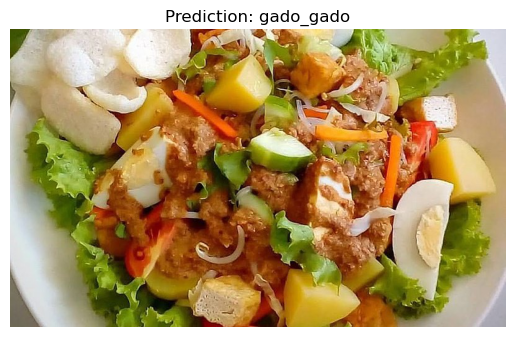

In [35]:
# Image testing prediction
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Gado_gado_jakarta.jpg/800px-Gado_gado_jakarta.jpg'

# Fetch image from URL
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Save the image to a local file
img_path = 'image_prediction.jpg'
img.save(img_path)

# Prediction using output function
prediction = output(img_path)

# Save the predicted image to a folder
output_img_path = f'result_prediction/{prediction}.jpg' 
img.save(output_img_path)

# Delete images after use
os.remove(img_path)

# Show images and their labels
plt.imshow(img)
plt.title(f'Prediction: {prediction}')
plt.axis('off')
plt.show()

# Convert Model ML

## Convert Model .h5

In [36]:
# Convert the model to .h5 format
model.save('save_model.h5')

## Convert Model .tflite

In [37]:
# Convert the model to tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('save_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpvmigzj_a/assets


INFO:tensorflow:Assets written to: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpvmigzj_a/assets
2023-12-10 19:55:29.774364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-10 19:55:29.774386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-10 19:55:29.775182: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpvmigzj_a
2023-12-10 19:55:29.796073: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-12-10 19:55:29.796092: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/wk/7nwswmks7mxgdqdw7s3pt6_c0000gn/T/tmpvmigzj_a
2023-12-10 19:55:29.869458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-12-10 19:55:29.892234: I tensorflow/cc/saved_model/load